# Importation des librairies et chargement des données

In [ ]:
pip install ucimlrepo

In [ ]:
pip install streamlit

In [ ]:
!npm install localtunnel

npm WARN saveError ENOENT: no such file or directory, open '/content/package.json'
npm notice created a lockfile as package-lock.json. You should commit this file.
npm WARN enoent ENOENT: no such file or directory, open '/content/package.json'
npm WARN content No description
npm WARN content No repository field.
npm WARN content No README data
npm WARN content No license field.

+ localtunnel@2.0.2
added 22 packages from 22 contributors and audited 22 packages in 1.546s

3 packages are looking for funding
  run `npm fund` for details

found 1 moderate severity vulnerability
  run `npm audit fix` to fix them, or `npm audit` for details


In [ ]:
#onehotencoding
#feature selection
#https://appdemo-7tzndkedryzmwgmavqoxgb.streamlit.app

In [ ]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from ucimlrepo import fetch_ucirepo
import re
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import resample
from scipy.stats import uniform
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import time

In [ ]:
from ucimlrepo import fetch_ucirepo


diabetes_130_us_hospitals_for_years_1999_2008 = fetch_ucirepo(id=296)
df = pd.read_csv("diabetic_data.csv")

# data (as pandas dataframes)
X = diabetes_130_us_hospitals_for_years_1999_2008.data.features
y = diabetes_130_us_hospitals_for_years_1999_2008.data.targets

# metadata
#print(diabetes_130_us_hospitals_for_years_1999_2008.metadata)

# variable information
#print(diabetes_130_us_hospitals_for_years_1999_2008.variables)


/usr/local/lib/python3.10/dist-packages/ucimlrepo/fetch.py:97: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_url)


In [ ]:
y.head()

,readmitted
0,NO
1,>30
2,NO
3,NO
4,NO


In [ ]:
X.head()

,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,...,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed
0,Caucasian,Female,[0-10),NaN,6,25,1,1,NaN,Pediatrics-Endocrinology,...,No,No,No,No,No,No,No,No,No,No
1,Caucasian,Female,[10-20),NaN,1,1,7,3,NaN,NaN,...,No,No,Up,No,No,No,No,No,Ch,Yes
2,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,NaN,NaN,...,No,No,No,No,No,No,No,No,No,Yes
3,Caucasian,Male,[30-40),NaN,1,1,7,2,NaN,NaN,...,No,No,Up,No,No,No,No,No,Ch,Yes
4,Caucasian,Male,[40-50),NaN,1,1,7,1,NaN,NaN,...,No,No,Steady,No,No,No,No,No,Ch,Yes


# Nettoyage basique et mise en forme des données

In [ ]:
missing_values_rate_by_column = (df.isnull().sum() / len(X)) * 100
print("taux de valeurs manquantes par colonne:",missing_values_rate_by_column, sep='\n')

taux de valeurs manquantes par colonne:
encounter_id                0.0
patient_nbr                 0.0
race                        0.0
gender                      0.0
age                         0.0
weight                      0.0
admission_type_id           0.0
discharge_disposition_id    0.0
admission_source_id         0.0
time_in_hospital            0.0
payer_code                  0.0
medical_specialty           0.0
num_lab_procedures          0.0
num_procedures              0.0
num_medications             0.0
number_outpatient           0.0
number_emergency            0.0
number_inpatient            0.0
diag_1                      0.0
diag_2                      0.0
diag_3                      0.0
number_diagnoses            0.0
max_glu_serum               0.0
A1Cresult                   0.0
metformin                   0.0
repaglinide                 0.0
nateglinide                 0.0
chlorpropamide              0.0
glimepiride                 0.0
acetohexamide               0.0


Certaines colonnes sont clairement utilisables : on va donc les supprimer

In [ ]:
df.drop(["weight", "medical_specialty", "payer_code"], axis=1, inplace=True)

In [ ]:
df['age']

0          [0-10)
1         [10-20)
2         [20-30)
3         [30-40)
4         [40-50)
           ...   
101761    [70-80)
101762    [80-90)
101763    [70-80)
101764    [80-90)
101765    [70-80)
Name: age, Length: 101766, dtype: object

on va maintenant rendre la colonne age utilisable : On va faire un choix arbitraire, celui de prendre le milieu de chaque intervalle afin d'avoir un seul et unique âge. La fonction ci-dessous va rechercher les nombres à l'aide d'une expression regex, et va ensuite faire la moyenne des deux nombres.

In [ ]:
def tranche_age(texte):
    nombres = re.findall(r'\d+', texte)
    nombres = list(map(int, nombres))
    return (sum(nombres)/2)

df['age']=df['age'].apply(tranche_age).astype(int)
print(df['age'])

0          5
1         15
2         25
3         35
4         45
          ..
101761    75
101762    85
101763    75
101764    85
101765    75
Name: age, Length: 101766, dtype: int64


# Mise en forme des données : mapping

Dans notre dataset, les colonnes diag_1, diag_2 et diag_3 correspondent aux différents diagnostics faits sur le patient. Cependant, ces données sont sous la forme de nombres suivant la classification médicale ICD9. Afin d'avoir leur équivalent en texte, nous sommes partis chercher sur internet un fichier répertoriant les nombres et leur signification. Nous avons fini par trouver le github d'une personne qui avait fait ce travail, et qui avait donc un fichier texte avec les codes et leur signification, avec un séparateur tabulation. Nous avons converti ce fichier en fichier csv et nous l'avons utilisé

explication : on fait un premapping, dans lequel on met juste les clé et les valeurs à partir du fichier excel.

Dans cette première partie, on fait un pré-mapping : On crée un dictionnaire dans lequel on met simplement les clés (codes ICD9) et les valeurs (description de la maladie) à partir du fichier excel

In [141]:
premapping_diag = {}

with open("file1.csv", 'r', encoding='ISO-8859-1') as file:
    next(file)  # pour ignorer l'en-tête
    for line in file:
        icd9code, long_description, _ = line.strip().split(',')[:3]  # Assurez-vous d'adapter cette étape à votre fichier CSV
        premapping_diag[icd9code] = long_description









En affichant ce dictionnaire, on s'aperçoit que les valeurs ne sont pas sous le même format que celles dans le tableau excel. on doit donc mettre ça sous la même forme. On va créer un nouveau dico qui s'appelle mapping, dans lequel on va "nettoyer" l'ancien dico avec des expressions regex. (voir à l'intérieur de la cellule pour plus de précisions)

In [142]:
mapping_diag = {}

for old_key, value in premapping_diag.items():
    new_key = old_key.lstrip("0")  # Supprime les zéros inutiles au début du nombre. exemple : 006 vaudra 6
    nk_v2=re.sub(r'\.0$', '', new_key)# Supprime les '.0' inutiles en fin de chaîne. exemple : 120.0 vaudra 120
    nk_v2=re.sub(r'\.00$', '', nk_v2)# Supprime les '.00' inutiles en fin de chaîne. exemple : 120.00 vaudra 120
    nk_v2=re.sub(r'\.$', '', nk_v2)# Supprime les '.' en fin de chaîne.
    if '.' in nk_v2:
        nk_v2= nk_v2.rstrip("0") #supprime le dernier chiffre quand c'est un zéro si et seulement si le nombre est un nombre à virgule.
    mapping_diag[nk_v2] = value  # Ajoute la nouvelle clé et sa valeur correspondante dans le nouveau dictionnaireif '.' in nk_v2:




la condition      if '.' in nk_v2       avant la ligne de code     nk_v2= nk_v2.rstrip("0")      permet de ne cibler que les nombres à virgules. Ainsi, on évite que les nombres entiers soient altérés, et qu'un 240 se transforme par exemple en 24

maintenant que les clés du dictionnaire et les valeurs dans le dataset sont sous la même forme, on peut commencer le mapping. Au lieu de remplacer la colonne diag_1, on va préférer créer une nouvelle colonne diag_lit_1 qui contiendra la description de la maladie, afin de ne pas perdre  cette colonne au cas où nous en aurions besoin plus tard.

In [ ]:
diags_lit = []
mauvaises_valeurs=[]
for value in df['diag_1']:
    if str(value) in mapping_diag.keys():
        diags_lit.append(mapping_diag[value])
    else:
        diags_lit.append(0)
        mauvaises_valeurs.append(value)



df['diag_lit_1'] = diags_lit

print((df['diag_lit_1'] == 0).sum())
valeurs_uniques = set(mauvaises_valeurs) #on convertit en set car il n'y a pas 2 fois la même valeur dans un set
print(valeurs_uniques)

4908
{'405', '558', 'V54', '645', '187', '585', '780', '445', '350', 'V53', '58', '275', 'V71', '?', '799', '584', '959', '323', 'V25', '787', '690', '362', '790', '444', '284'}


Ici , on a utilisé une liste dans laquelle on rajoute les valeurs qui ne sont pas dans le dictionnaire mais qui sont dans le dataset. Si la valeur n'est pas dans le dictionnaire, on remplace par 0

En regardant bien, on voit qu'il reste 4908 zéros, et qu'une vingtaine de codes ne matchent pas ceux dans notre dictionnaire. On a d'abord cru qu'on avait mal mis en forme les numéros, mais on s'est aperçus que ces valeurs ne sont juste pas présentes dans le dictionnaire. On comprend donc que le fichier qu'on a récupéré ne contenait  pas tous les codes. Pas le choix, on va devoir rajouter ces codes à la main. Par chance, il n'y en a pas beaucoup.

In [ ]:
#mettre les 0

In [ ]:
cle=['780', '787', '350', '362', '585', '558', 'V53', 'V54', 'V25', '187', '799', '645', '284', '275', '959', '445', '444', '690', '323', '58', '790', '405', 'V71', '276', '584']
valeurs=['General symptoms', 'Symptoms involving digestive system','rigeminal nerve disorders', 'Other retinal disorders', 'Chronic kidney disease (ckd)', 'Other and unspecified noninfectious gastroenteritis and colitis', 'Fitting and adjustment of other device', 'Other orthopedic aftercare', 'Encounter for contraceptive management', 'Malignant neoplasm of penis and other male genital organs', 'Other ill-defined and unknown causes of morbidity and mortality', 'Late pregnancy', 'Aplastic anemia and other bone marrow failure syndromes', 'Disorders of mineral metabolism', 'Injury other and unspecified', 'Atheroembolism', 'Arterial embolism and thrombosis', 'Erythematosquamous dermatosis', 'Meningitis of unspecified cause', 'Other human herpesvirus', 'Nonspecific findings on examination of blood', 'Secondary hypertension', 'Observation and evaluation for suspected conditions not found', 'Disorders of fluid electrolyte and acid-base balance', 'Acute kidney failure']

for i in range(len(cle)):
    mapping_diag[cle[i]]=valeurs[i]


on rééxécute le mapping après avoir mis à jour notre dictionnaire

In [ ]:
diags_lit = []
mauvaises_valeurs=[]
for value in df['diag_1']:
    if str(value) in mapping_diag.keys():
        diags_lit.append(mapping_diag[value])
    else:
        diags_lit.append(0)
        mauvaises_valeurs.append(value)


# Assignez la liste complète à la colonne diag_lit_1
df['diag_lit_1'] = diags_lit

# Vérifiez le compte des zéros
print((df['diag_lit_1'] == 0).sum())
valeurs_uniques = set(mauvaises_valeurs) #on convertit en set car ça nous donnera les clé absentes du dictionnaire mais sans doublons
print(valeurs_uniques)

21
{'?'}


on voit qu'il reste 21 valeurs inconnues. Pour rappel, on avait décidé de remplacer par 0 en attendant de trouver une solution. Ici, on peut juste les remplacer par 'Uknown/not done' car on ne sait pas s'il manque l'information sur le diagnostic ou si le diagnostic n'a juste pas été fait

In [ ]:
df['diag_lit_1']=df['diag_lit_1'].replace(0,'Unknown / Not done')
print((df['diag_lit_1'] == 0).sum())

0


On applique ensuite tout ce raisonnement aux colonnes diag_2 et diag_3

In [ ]:
diags_lit = []
mauvaises_valeurs=[]
for value in df['diag_2']:
    if str(value) in mapping_diag.keys():
        diags_lit.append(mapping_diag[value])
    else:
        diags_lit.append(0)
        mauvaises_valeurs.append(value)



df['diag_lit_2'] = diags_lit
print((df['diag_lit_2'] == 0).sum())

valeurs_uniques = set(mauvaises_valeurs) #on convertit en set car il n'y a pas 2 fois la même valeur dans un set
print(valeurs_uniques)

513
{'V15', '484', '258', 'V61', '517', '?', '712'}


même procédé, on va rajouter ces valeurs à la main et réitérer la cellule après

In [ ]:
cle2=['517', 'V61', '258', '484', 'V15', '712']
val2=['Lung involvement in conditions classified elsewhere', 'Other family circumstances', 'Polyglandular dysfunction and related disorders', 'Pneumonia in infectious diseases classified elsewhere', 'Other personal history presenting hazards to health', 'Crystal arthropathies']
for i in range(len(cle2)):
    mapping_diag[cle2[i]]=val2[i]

In [ ]:
diags_lit = []
mauvaises_valeurs=[]
for value in df['diag_2']:
    if str(value) in mapping_diag.keys():
        diags_lit.append(mapping_diag[value])
    else:
        diags_lit.append(0)
        mauvaises_valeurs.append(value)


df['diag_lit_2'] = diags_lit


print((df['diag_lit_2'] == 0).sum())

valeurs_uniques = set(mauvaises_valeurs) #on convertit en set car il n'y a pas 2 fois la même valeur dans un set
print(valeurs_uniques)

358
{'?'}


pour les nan, on va rajouter unknown

In [ ]:
df['diag_lit_2']=df['diag_lit_2'].replace(0,'Unknown / Not done')
print((df['diag_lit_2'] == 0).sum())

0


même chose pour diag_3

In [ ]:
diags_lit = []
mauvaises_valeurs=[]
for value in df['diag_3']:
    if str(value) in mapping_diag.keys():
        diags_lit.append(mapping_diag[value])
    else:
        diags_lit.append(0)
        mauvaises_valeurs.append(value)



df['diag_lit_3'] = diags_lit


print((df['diag_lit_3'] == 0).sum())
valeurs_uniques = set(mauvaises_valeurs) #on convertit en set car il n'y a pas 2 fois la même valeur dans un set
print(valeurs_uniques)

1425
{'624', '?'}


In [ ]:
mapping_diag['624']='Noninflammatory disorders of vulva and perineum'

In [ ]:
diags_lit = []
mauvaises_valeurs=[]
for value in df['diag_3']:
    if str(value) in mapping_diag.keys():
        diags_lit.append(mapping_diag[value])
    else:
        diags_lit.append(0)
        mauvaises_valeurs.append(value)


df['diag_lit_3'] = diags_lit


print((df['diag_lit_3'] == 0).sum())
valeurs_uniques = set(mauvaises_valeurs) #on convertit en set car il n'y a pas 2 fois la même valeur dans un set
print(valeurs_uniques)

1423
{'?'}


remplacement des nan:

In [ ]:
df['diag_lit_3']=df['diag_lit_3'].replace(0,'Unknown / Not done')
print((df['diag_lit_3'] == 0).sum())

0


Lorsqu'on télécharge notre dataset, on a 2 fichiers : le premier est diabetic_data, c'est notre dataset. Le deuxième est un fichier nommé IDS_mapping, qui contient la description littérale de plusieurs colonnes à laquelle on a attribué des valeurs. On va donc également faire du mapping avec ce fichier

In [ ]:
data = pd.read_csv('IDS_mapping.csv')

In [ ]:
data.columns

Index(['admission_type_id', 'description'], dtype='object')

on va d'abord récupérer les données pour l'admission (9 premières lignes)

In [ ]:
donnees = data.iloc[0:8]

admission = {}
for index, row in donnees.iterrows():
    admission[row['admission_type_id']] = row['description']

print(admission)


{'1': 'Emergency', '2': 'Urgent', '3': 'Elective', '4': 'Newborn', '5': 'Not Available', '6': nan, '7': 'Trauma Center', '8': 'Not Mapped'}


on fait quelques modifications sur la valeur 6 : on va remplacer les valeurs nan par 'unknown' pour ne pas avoir d'erreurs

In [ ]:
admission['6']='Unknown'
print(admission)

{'1': 'Emergency', '2': 'Urgent', '3': 'Elective', '4': 'Newborn', '5': 'Not Available', '6': 'Unknown', '7': 'Trauma Center', '8': 'Not Mapped'}


ici, on a d'abord sélectionné les données (on utilisa data.iloc pour se baser sur la position de la ligne et non son index)
ensuite, on a utilisé la méthode .iterrows() de panda qui permet de parcourir toutes les lignes d'un dataframe, et on a ajouté les infos correspondantes dans le dico

note : data.iloc[0] psk les colonnes ont été enlevés, donc pour avoir la première ligne on réindexe

on va maintenant récupérer les données de la colonne discharge suivant la même méthode (lignes 11 à 41)

In [ ]:
donnees = data.iloc[10:41]

discharge = {}
for index, row in donnees.iterrows():
    discharge[row['admission_type_id']] = row['description']

print(discharge)

{'1': 'Discharged to home', '2': 'Discharged/transferred to another short term hospital', '3': 'Discharged/transferred to SNF', '4': 'Discharged/transferred to ICF', '5': 'Discharged/transferred to another type of inpatient care institution', '6': 'Discharged/transferred to home with home health service', '7': 'Left AMA', '8': 'Discharged/transferred to home under care of Home IV provider', '9': 'Admitted as an inpatient to this hospital', '10': 'Neonate discharged to another hospital for neonatal aftercare', '11': 'Expired', '12': 'Still patient or expected to return for outpatient services', '13': 'Hospice / home', '14': 'Hospice / medical facility', '15': 'Discharged/transferred within this institution to Medicare approved swing bed', '16': 'Discharged/transferred/referred another institution for outpatient services', '17': 'Discharged/transferred/referred to this institution for outpatient services', '18': nan, '19': 'Expired at home. Medicaid only, hospice.', '20': 'Expired in a m

on répète le procédé une 3ème fois pour la colonne admission_source (lignes 43 à 68)

In [ ]:
donnees = data.iloc[42:68]

source = {}
for index, row in donnees.iterrows():
    source[row['admission_type_id']] = row['description']

print(source)

{'1': ' Physician Referral', '2': 'Clinic Referral', '3': 'HMO Referral', '4': 'Transfer from a hospital', '5': ' Transfer from a Skilled Nursing Facility (SNF)', '6': ' Transfer from another health care facility', '7': ' Emergency Room', '8': ' Court/Law Enforcement', '9': ' Not Available', '10': ' Transfer from critial access hospital', '11': 'Normal Delivery', '12': ' Premature Delivery', '13': ' Sick Baby', '14': ' Extramural Birth', '15': 'Not Available', '17': nan, '18': ' Transfer From Another Home Health Agency', '19': 'Readmission to Same Home Health Agency', '20': ' Not Mapped', '21': 'Unknown/Invalid', '22': ' Transfer from hospital inpt/same fac reslt in a sep claim', '23': ' Born inside this hospital', '24': ' Born outside this hospital', '25': ' Transfer from Ambulatory Surgery Center', '26': 'Transfer from Hospice'}


on a maintenant nos 3 dictionnaires, il ne nous reste plus qu'à faire le mapping

pour le mapping, on va créer de nouvelles colonnes plutôt que d'écraser les valeurs des anciennes. On va donc faire comme pour les diagnostics

In [ ]:
admissions_lit = []
mauvaises_valeurs=[]
for value in df['admission_type_id']:
    if str(value) in admission.keys():
        admissions_lit.append(admission[str(value)])
    else:
        admissions_lit.append(0)
        mauvaises_valeurs.append(value)



df['admission_type'] = admissions_lit

# on vérifie les valeurs manquantes
valeurs_uniques = set(mauvaises_valeurs) #on convertit en set car il n'y a pas 2 fois la même valeur dans un set
print(valeurs_uniques)

set()


le set des valeurs manquantes est vide, donc le mapping a été correctement exécuté. On va maintenant faire la même chose pour  les deux autres dictionnaires

In [ ]:
source_lit = []
mauvaises_valeurs=[]
for value in df['admission_source_id']:
    if str(value) in source.keys():
        source_lit.append(source[str(value)])
    else:
        source.append(0)
        mauvaises_valeurs.append(value)



df['source_lit'] = source_lit


valeurs_uniques = set(mauvaises_valeurs) #on convertit en set car il n'y a pas 2 fois la même valeur dans un set
print(valeurs_uniques)

set()


In [ ]:
discharge_lit = []
mauvaises_valeurs=[]
for value in df['discharge_disposition_id']:
    if str(value) in discharge.keys():
        discharge_lit.append(discharge[str(value)])
    else:
        discharge_lit.append(0)
        mauvaises_valeurs.append(value)



df['discharge_lit'] = discharge_lit


valeurs_uniques = set(mauvaises_valeurs) #on convertit en set car il n'y a pas 2 fois la même valeur dans un set
print(valeurs_uniques)

set()


on vient donc de créer 3 nouvelles colonnes : admission_lit, source_lit et discharge_lit qui contiennent les descriptions littérales associées au numéros dans les colonnes admisison, source et discharge

# graphiques


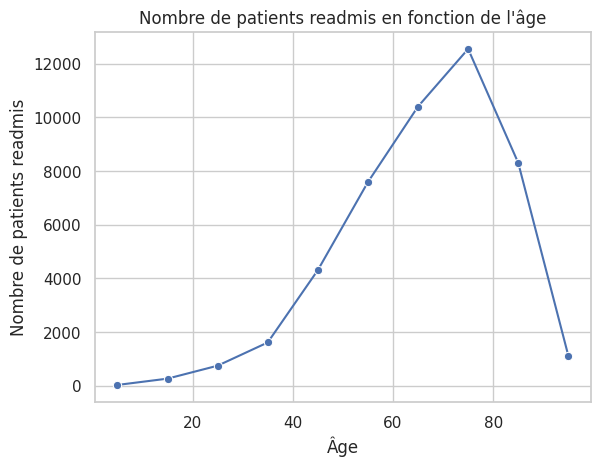

In [ ]:
mapping = {"<30":1,">30":1,"no":0}
df_ = df.copy()
df_["readmitted"] = df_["readmitted"].map(mapping)
readmitted_by_age = df_.groupby('age')['readmitted'].sum().reset_index(name='count')
sns.lineplot(data=readmitted_by_age, x='age', y='count', marker='o')
plt.title('Nombre de patients readmis en fonction de l\'âge')
plt.xlabel('Âge')
plt.ylabel('Nombre de patients readmis')
plt.grid(True)
plt.savefig('read_age.png')
plt.show()

726.0


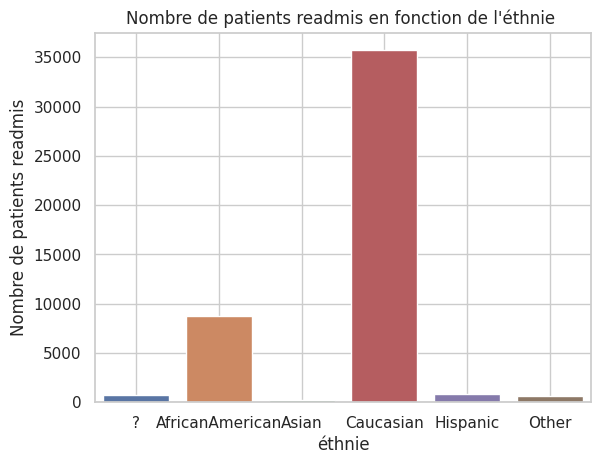

In [ ]:
df_=df.copy()
mapping = {"<30":1,">30":1,"no":0}
df_['readmitted']=df_['readmitted'].map(mapping)
readmitted_by_race = df_.groupby('race')['readmitted'].sum().reset_index(name='count')
print(readmitted_by_race['count'][0])

sns.barplot(data=readmitted_by_race, x='race', y='count')
plt.title("Nombre de patients readmis en fonction de l'éthnie ")
plt.xlabel('éthnie')
plt.ylabel('Nombre de patients readmis')
plt.grid(True)
plt.savefig('read_ethnie.png')
plt.show()

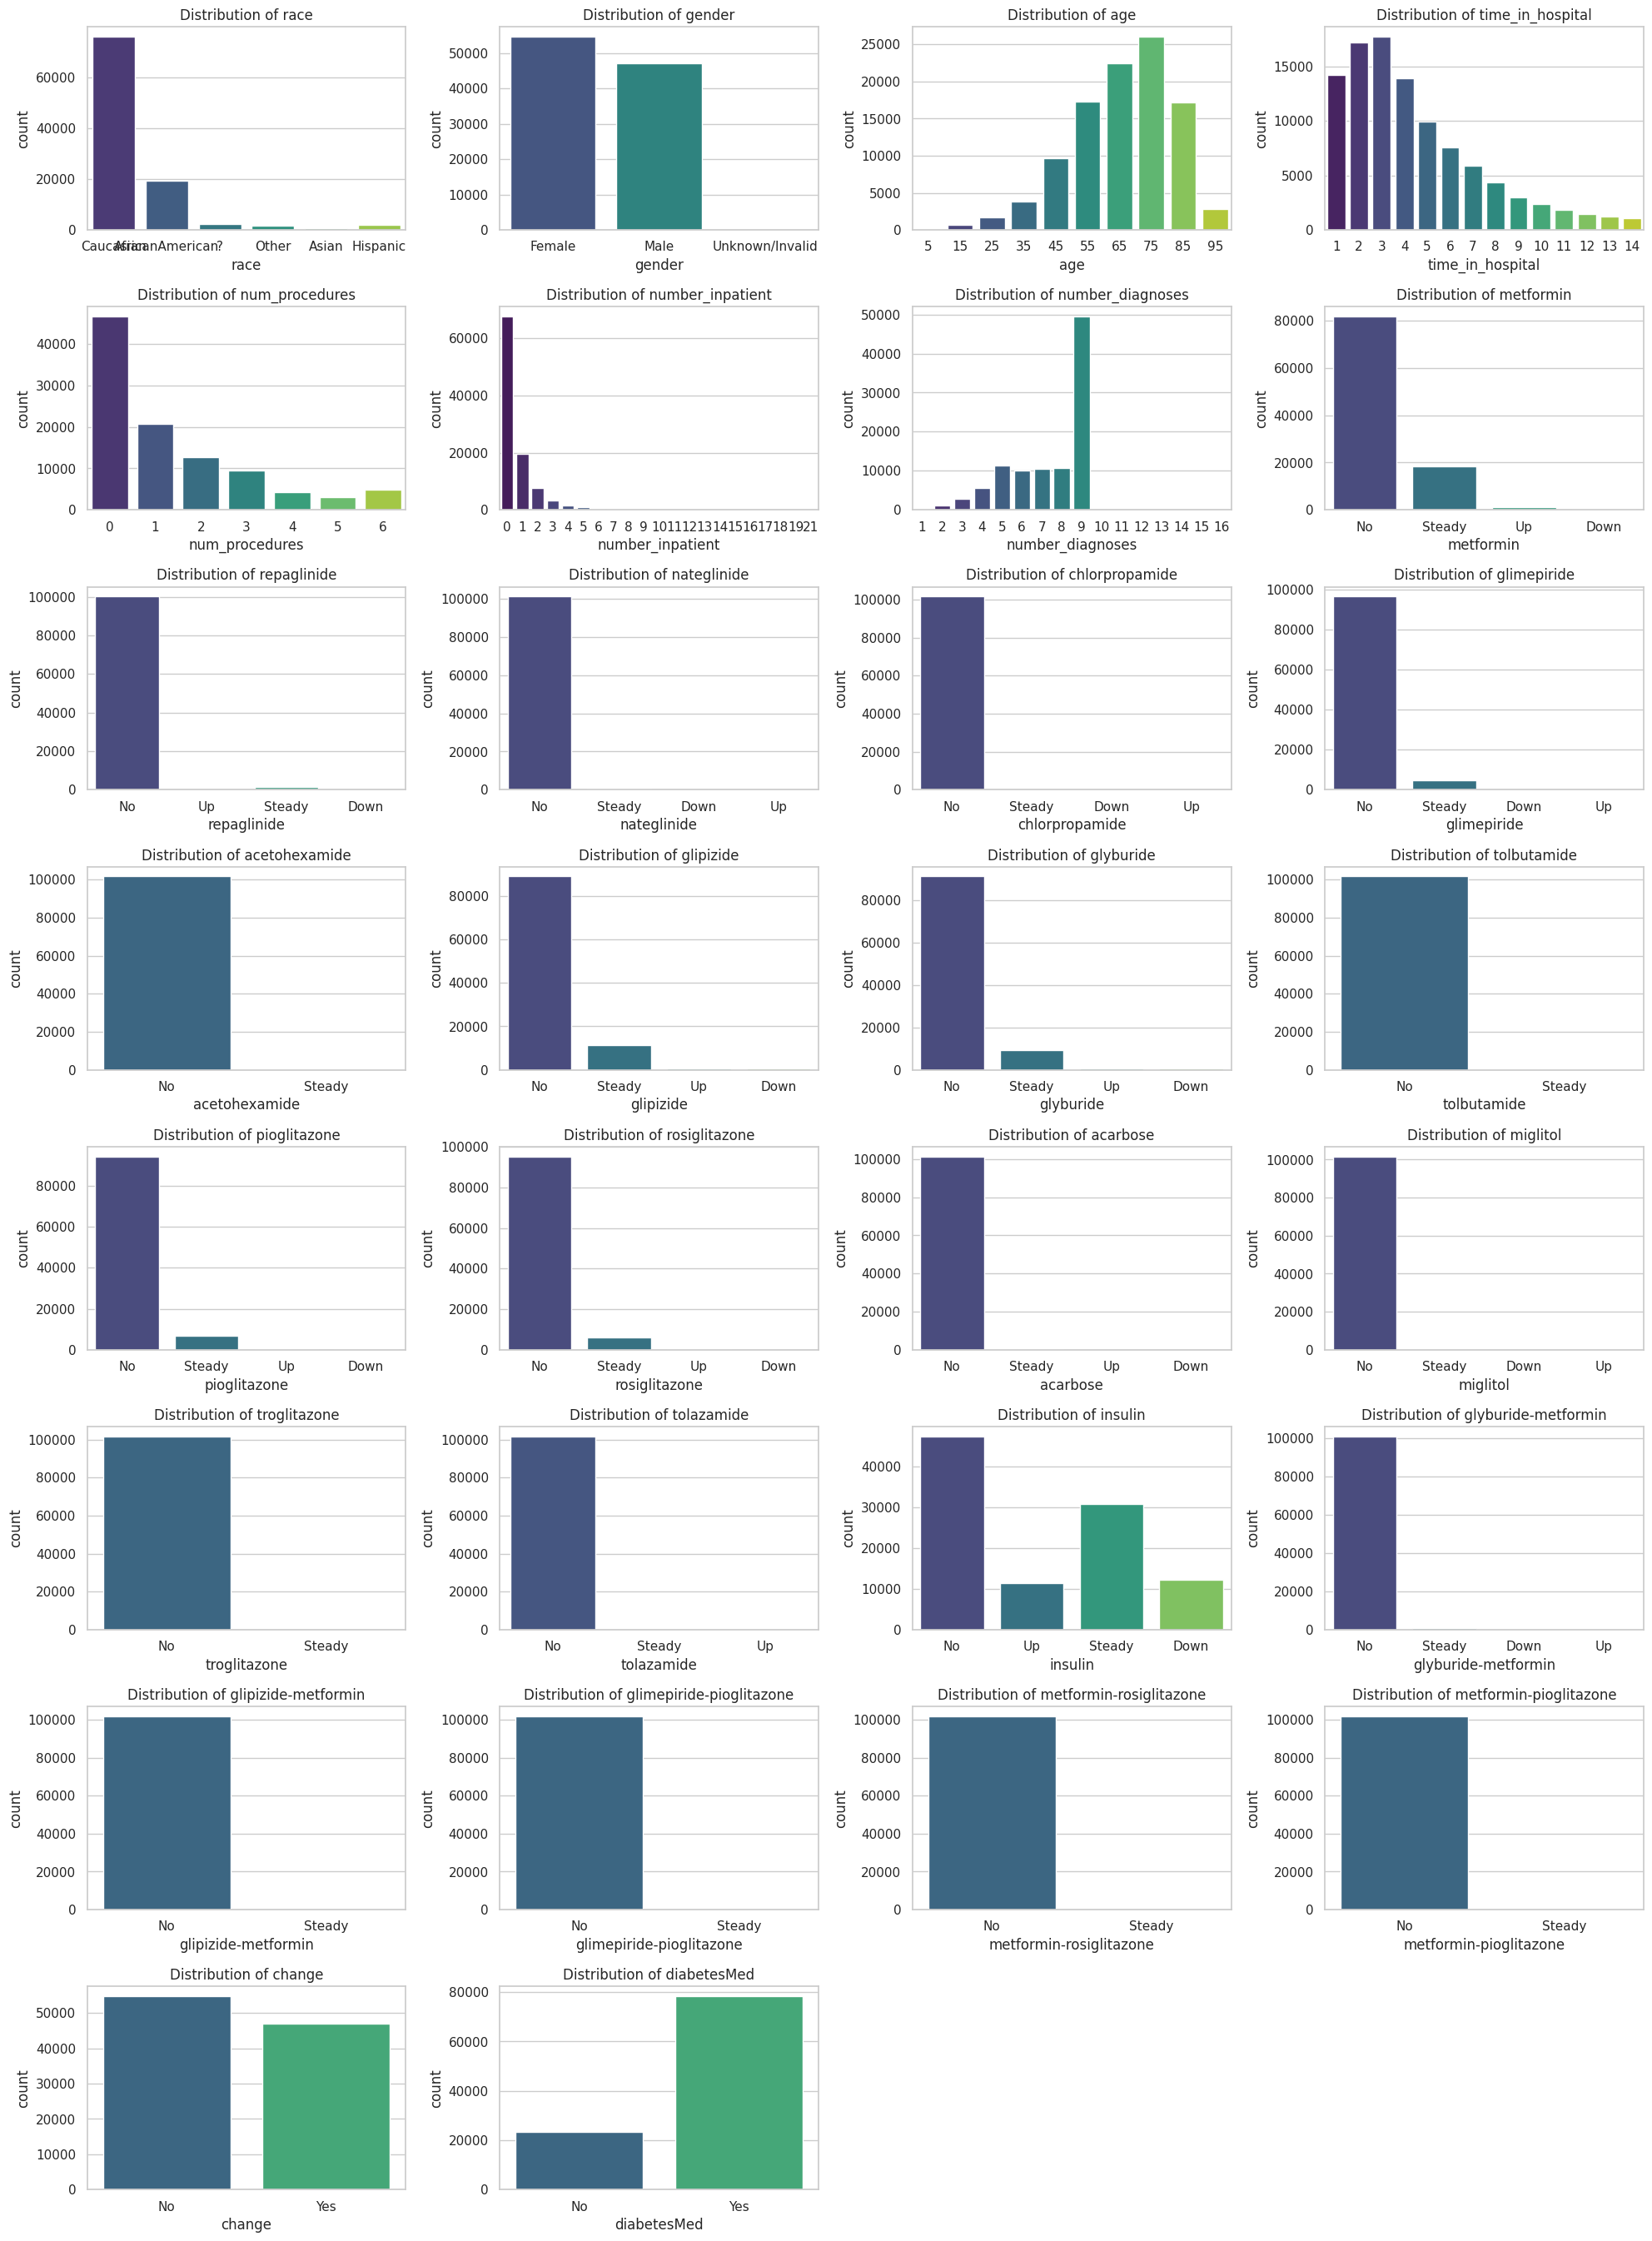

In [ ]:

sns.set(style="whitegrid")

plt.figure(figsize=(20, 40))

columns_to_visualize = ['race', 'gender', 'age', 'time_in_hospital',
       'num_procedures',  'number_inpatient',  'number_diagnoses',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide',  'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed']



df['change']=df['change'].replace('Ch','Yes')
for i, column in enumerate(columns_to_visualize, 1):
    plt.subplot(12, 4, i)
    sns.countplot(x=column, data=df, palette='viridis')
    plt.title(f'Distribution of {column}')


plt.tight_layout()
plt.savefig('distribution.png')
plt.show()

Nous avons voulu faire un graphique montrant la répartition des admissions à l'hôpital. Malheureusement, comme les catégories Newborn, Trauma Center et not Mapped sont beaucoup trop petites, les écritures se sont superposées. Nous avons essayé de faire une légende distincte, mais cela n'a pas marché et nous avons donc laissé ce graphique tel quel

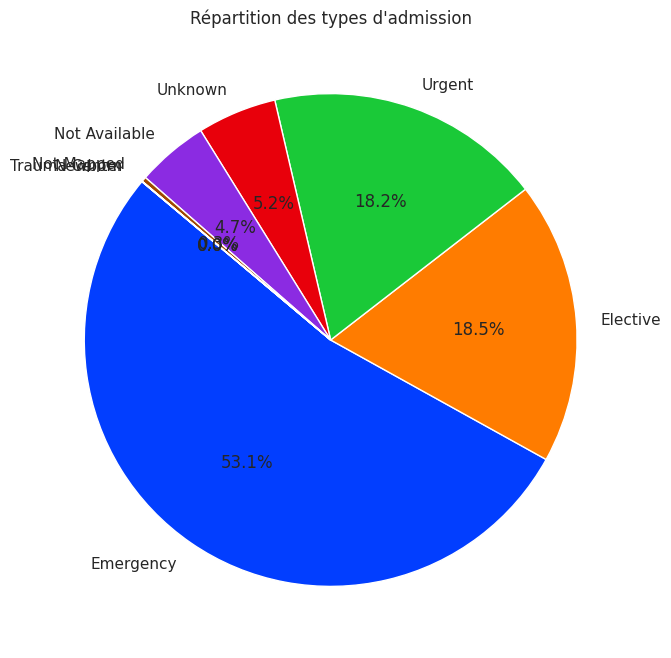

In [ ]:
admission_counts = df['admission_type'].value_counts()
colors = sns.color_palette('bright')

plt.figure(figsize=(8, 8))
plt.pie(admission_counts, labels=admission_counts.index, autopct='%1.1f%%', startangle=140, colors=colors)

plt.gca().set_aspect('equal')  # Assure un aspect ratio égal pour un cercle

plt.title('Répartition des types d\'admission')
plt.savefig('pie_chart.png')
plt.show()


Notre deuxième graphique représente le nombre de prescriptions par médicaments.

insulin                     54383
metformin                   19988
glipizide                   12686
glyburide                   10650
pioglitazone                 7328
rosiglitazone                6365
glimepiride                  5191
repaglinide                  1539
glyburide-metformin           706
nateglinide                   703
acarbose                      308
chlorpropamide                 86
tolazamide                     39
miglitol                       38
tolbutamide                    23
glipizide-metformin            13
troglitazone                    3
metformin-rosiglitazone         2
acetohexamide                   1
glimepiride-pioglitazone        1
metformin-pioglitazone          1
examide                         0
citoglipton                     0
dtype: int64


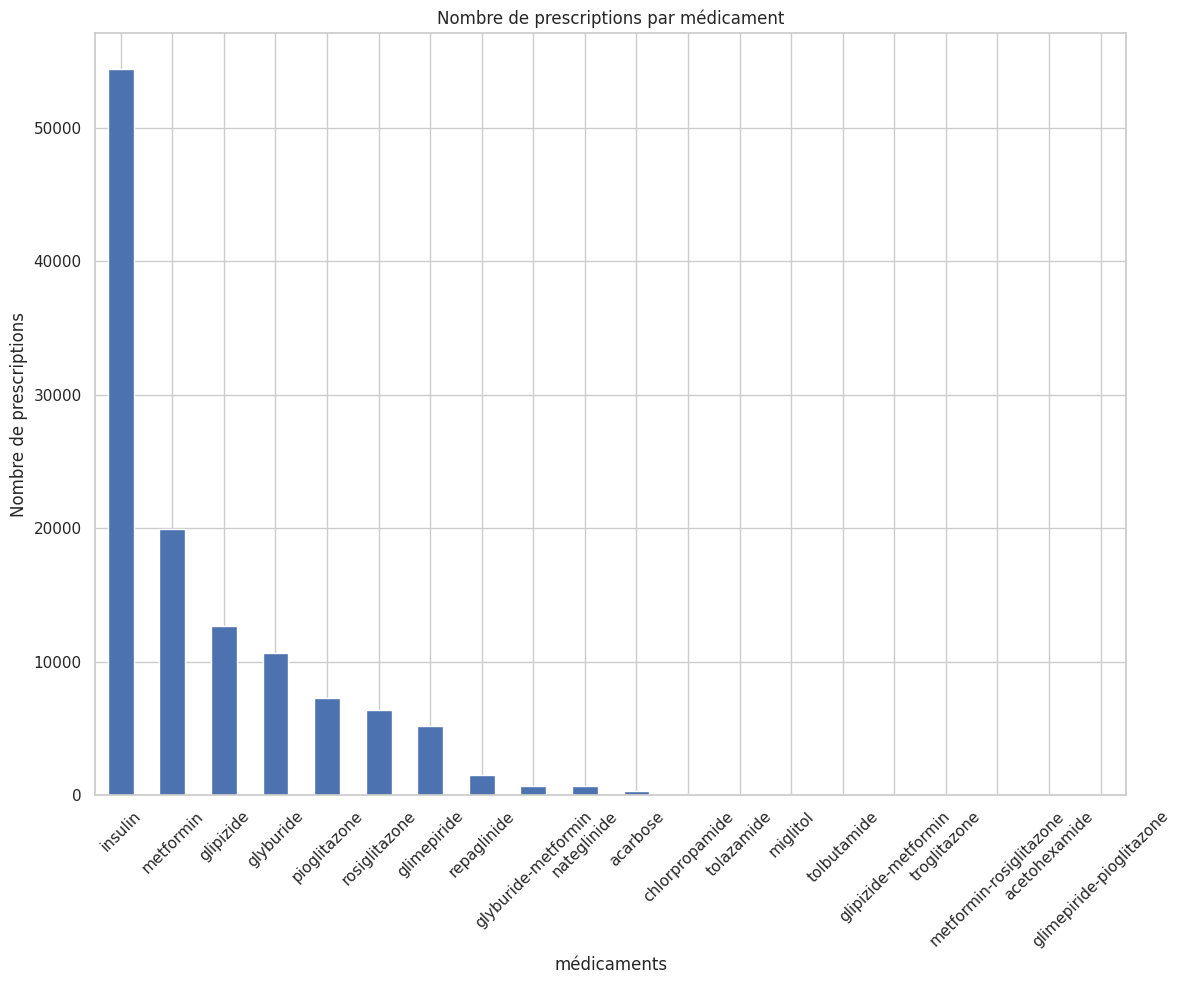

In [ ]:
df_medic= df.loc[:, 'metformin':'metformin-pioglitazone']
df_medic.replace(['Steady', 'Up', 'Down'], 'Yes', inplace=True) # On simplifie le dataframe pour savoir si le médicament a été administré ou non.
nombre_yes = df_medic.eq('Yes').sum() #permet de  faire la somme des éléments qui sont égal à 'Oui'
print(nombre_yes.sort_values(ascending=False))

col_med = nombre_yes.sort_values(ascending=False).head(20)

plt.figure(figsize=(12, 10))
col_med.plot.bar()
plt.xlabel('médicaments')
plt.ylabel('Nombre de prescriptions')
plt.title('Nombre de prescriptions par médicament')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('prescription_vertical.png')
plt.show()

On peut voir que l'insuline domine largement les prescriptions, à l'inverse de mélanges comme le glipizide-metformin par exemple, dont les prescriptions sont très rare. C'est dû à 2 choses : d'abord, ces mélanges étaient plutôt nouveaux dans les années 2000, donc pas encore adoptés par tout le monde contrairement à l'insuline. Ensuite, le prix: on achète deux médicaments pour en faire un mélange, et aux USA, les médicaments coûtent beaucoup plus cher qu'ici.

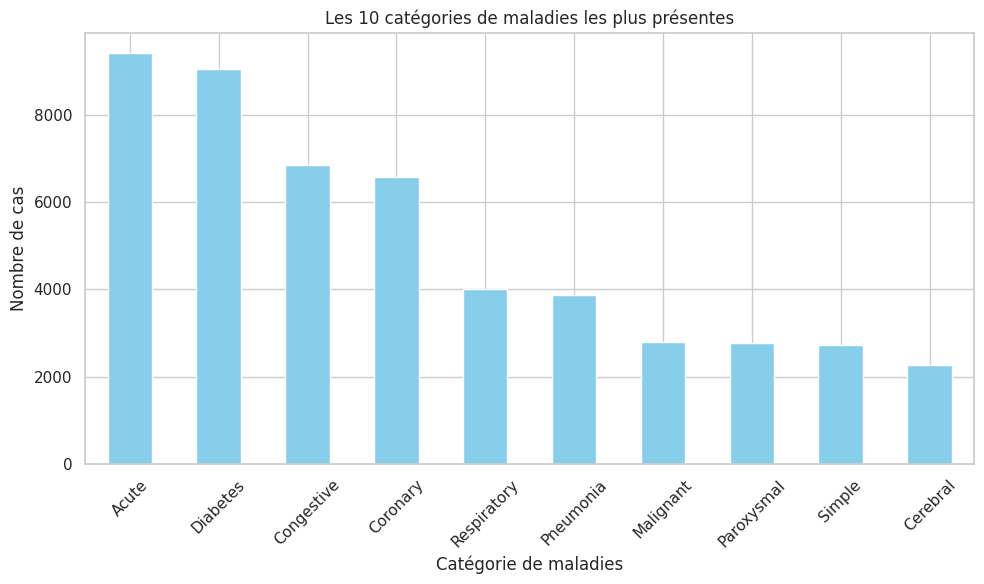

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

top_10_maladies = df['diag_lit_1'].str.split().str[0].value_counts().head(10)

plt.figure(figsize=(10, 6))
top_10_maladies.plot(kind='bar', color='skyblue')
plt.xlabel('Catégorie de maladies')
plt.ylabel('Nombre de cas')
plt.title('Les 10 catégories de maladies les plus présentes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


nous avons essayé de faire un top 10 des maladies les plus présentes.Comme nos colonnes diagnostics sont très détaillés (par exemple, il y a 7 catégories de salmonelle différentes), nous avons essayé de compter uniquement le premier mot, qui aurait été selon nous le nom générique de la maladie. Cela nous aurait permis de regrouper toutes les catégories de fièvres différente dans une seule et même catégorie. Malheureusement, notre graphique s'est retrouvé faussé car il y a également des ajdectifs qui se sont glissés dans le top 10 (comme le premier par exemple, qui signifie simplement aigu). Ce problème vient du fait que nos données sont en anglais, et que les adjectifs sont donc placés avant les noms de maladies (exemple : diarrhée aigüe= acute diarrhea, l'algorithme va donc récupérer le mot acute)  
cependant, on ne peut pas non plus prendre le 2ème mot de la description car si la maladie n'a pas d'adjectif associé, ça ne retournera rien( par exemple 'typhus').

On a également essayé de ne pas regrouper en catégories et de laisser les noms de maladies exactes, mais ce n'était pas très lisible (exemple ci-dessous avec les premiers diagnostics)

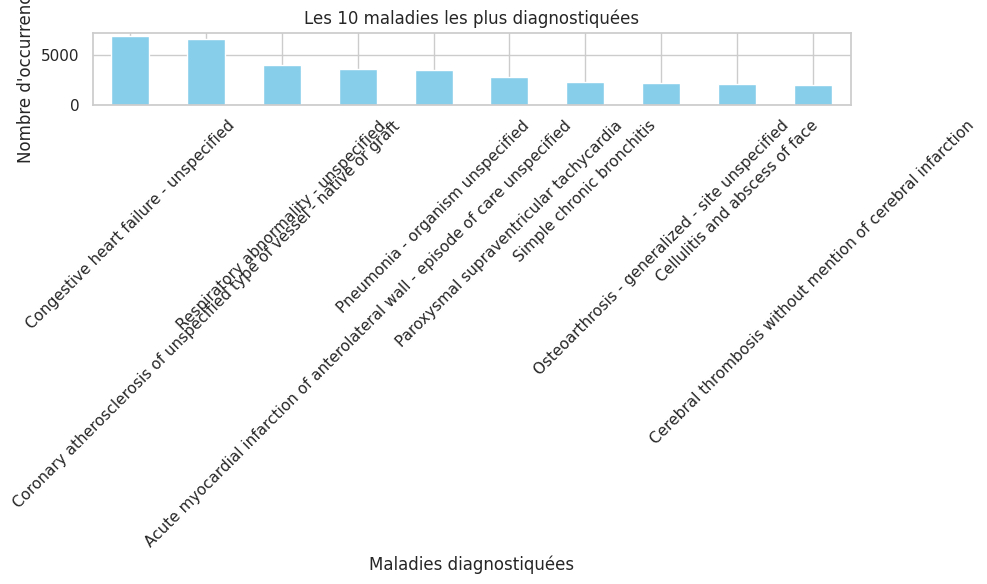

In [ ]:
occurrences_maladies = df['diag_lit_1'].value_counts()

top_10_maladies = occurrences_maladies.head(10)

plt.figure(figsize=(10, 6))
top_10_maladies.plot(kind='bar', color='skyblue')
plt.xlabel('Maladies diagnostiquées')
plt.ylabel('Nombre d\'occurrences')
plt.title('Les 10 maladies les plus diagnostiquées')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Suite à ça, on a décidé de ne pas essayer de regrouper les sous catégories et de laisser le nom exact de la maladie, tout en changeant de type de graphique (piechart). Nous avons fait ça pour les 3 diagnostics différents. Cependant, comme les noms de maladies sont très détaillés, le graphique est vite devenu illisible (voir ci-dessous)

<ipython-input-122-41418597f1bc>:26: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


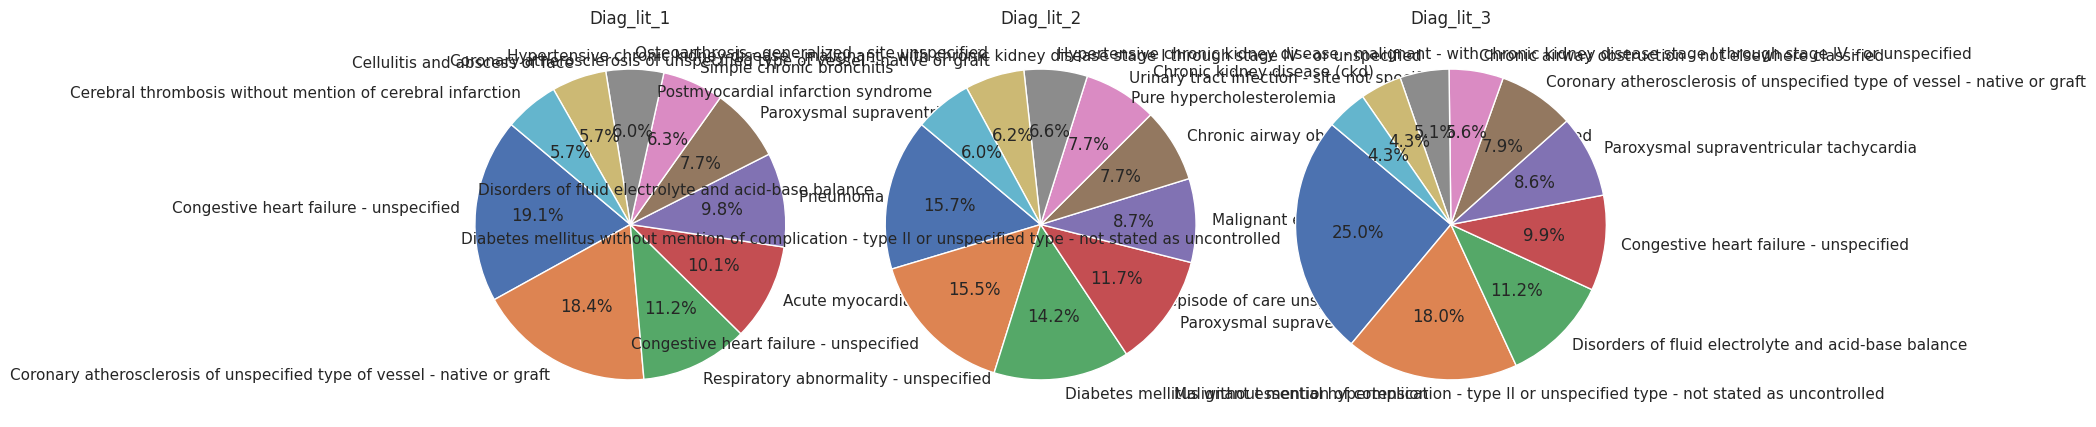

In [ ]:


occurrences_maladies_2 = df['diag_lit_2'].value_counts()
top_10_maladies_2 = occurrences_maladies_2.head(10)


occurrences_maladies_3 = df['diag_lit_3'].value_counts()
top_10_maladies_3 = occurrences_maladies_3.head(10)


plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.pie(top_10_maladies, labels=top_10_maladies.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.title('Diag_lit_1')

plt.subplot(132)
plt.pie(top_10_maladies_2, labels=top_10_maladies_2.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.title('Diag_lit_2')

plt.subplot(133)
plt.pie(top_10_maladies_3, labels=top_10_maladies_3.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.title('Diag_lit_3')

plt.tight_layout()
plt.show()


Nous avons donc voulu afficher ces graphiques un à un. Cependant, on s'est rendu compte plus tard que les graphiques étaient faussés sous la forme de piechart car la somme des pourcentages valait 100%, alors qu'il ne s'agit que des 10 symptômes les plus diagnostiqués. Nous avons donc décidé de faire des barplot horizontals simples. Les piechart individuels sont erronés, mais nous avons tout de même laisser les codes afin que vous compreniez la démarche.

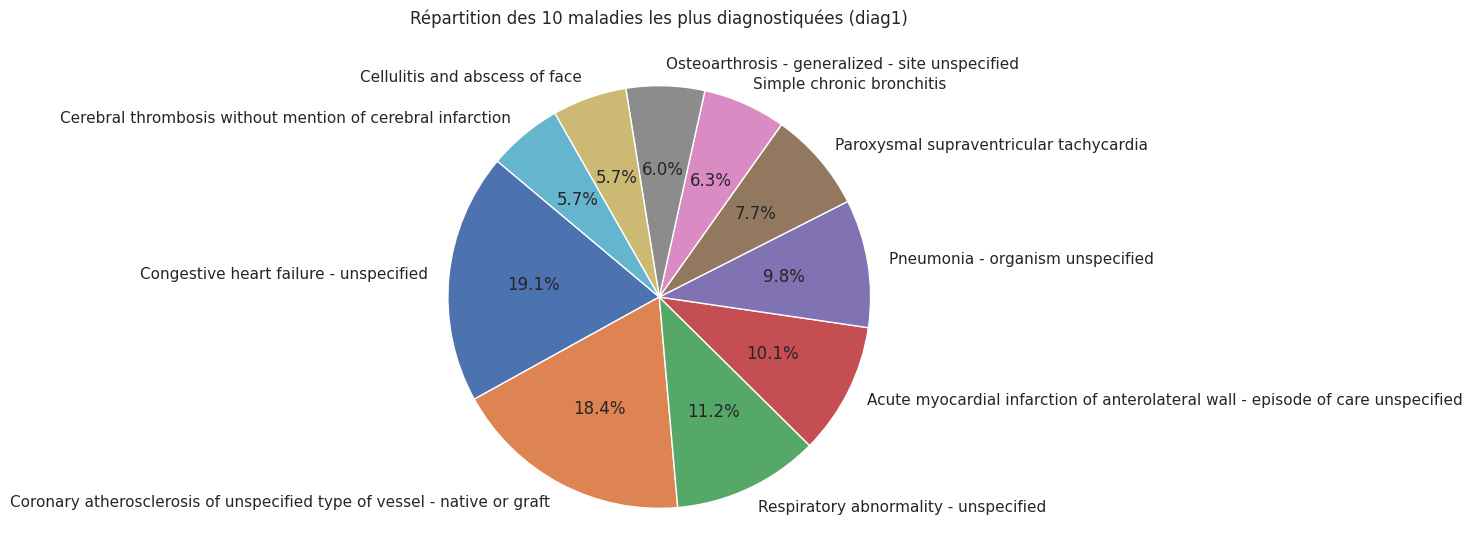

In [ ]:
occurrences_maladies = df['diag_lit_1'].value_counts()
top_10_maladies_1 = occurrences_maladies.head(10)

plt.figure(figsize=(6, 6))
plt.pie(top_10_maladies_1, labels=top_10_maladies_1.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.title('Répartition des 10 maladies les plus diagnostiquées (diag1)',pad=30)
plt.show()


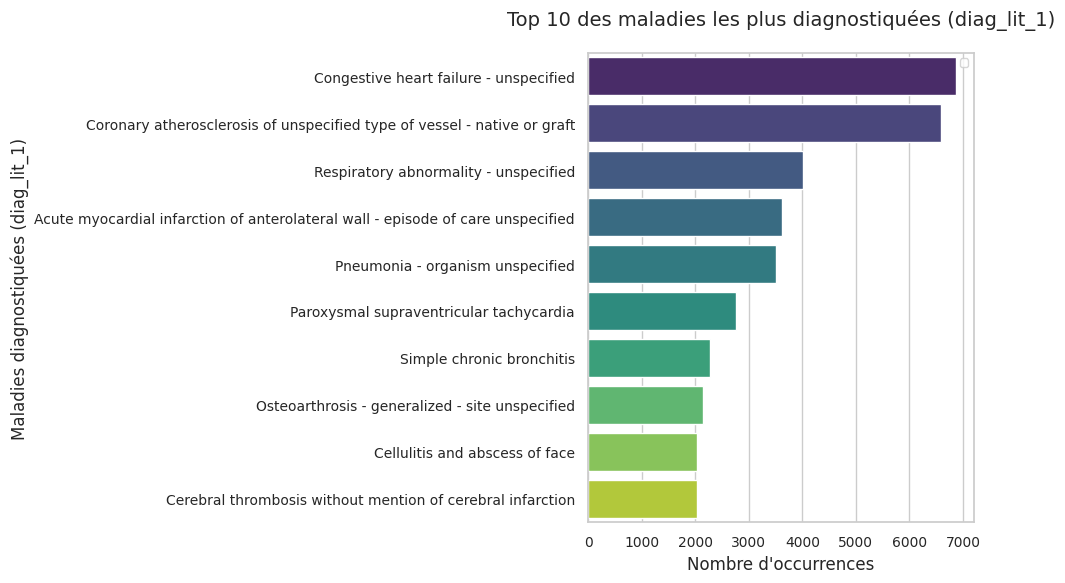

In [ ]:
test_diag_lit_1 = df['diag_lit_1'].value_counts().head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=test_diag_lit_1.values, y=test_diag_lit_1.index, palette='viridis')
plt.xlabel('Nombre d\'occurrences', fontsize=12)
plt.ylabel('Maladies diagnostiquées (diag_lit_1)', fontsize=12)
plt.title('Top 10 des maladies les plus diagnostiquées (diag_lit_1)', fontsize=14, pad=20)
plt.tick_params(labelsize=10)
plt.tight_layout()

plt.legend(loc='upper right', prop={'size': 8})

plt.savefig('top10_diag1.png')
plt.show()

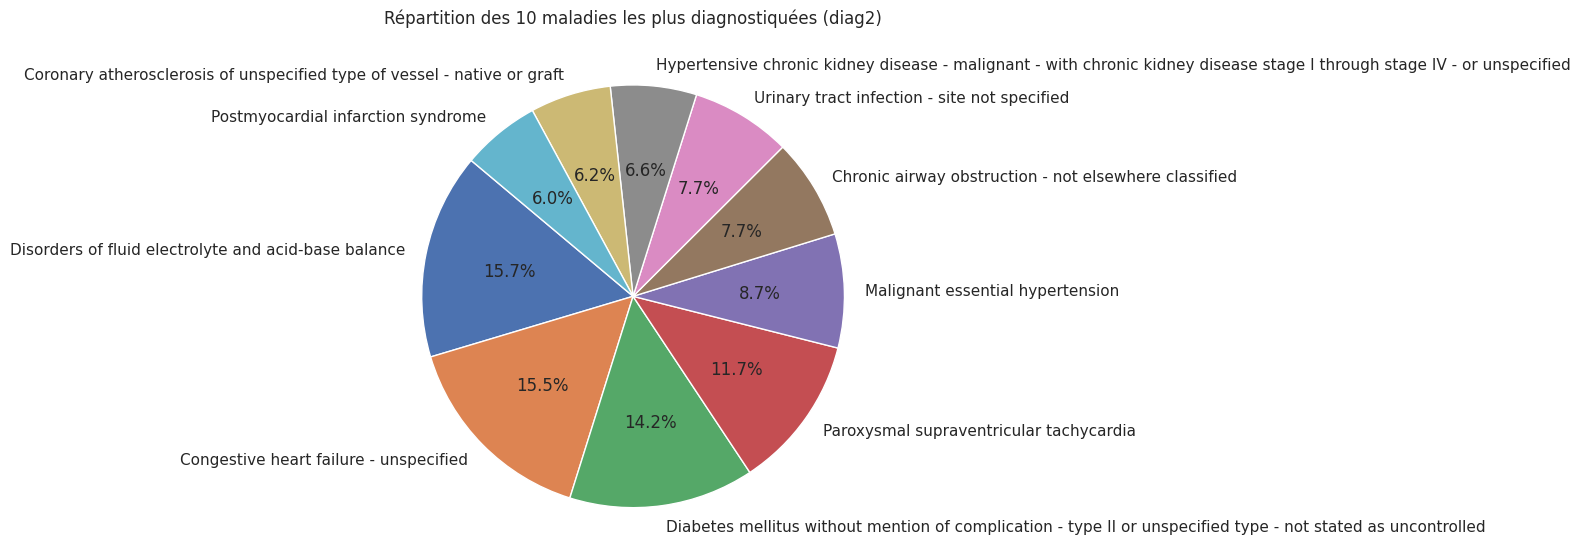

In [ ]:
occurrences_maladies = df['diag_lit_2'].value_counts()
top_10_maladies_2 = occurrences_maladies.head(10)


plt.figure(figsize=(6, 6))
plt.pie(top_10_maladies_2, labels=top_10_maladies_2.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.title('Répartition des 10 maladies les plus diagnostiquées (diag2)',pad=30)
plt.show()


<ipython-input-126-813b85680bbe>:9: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


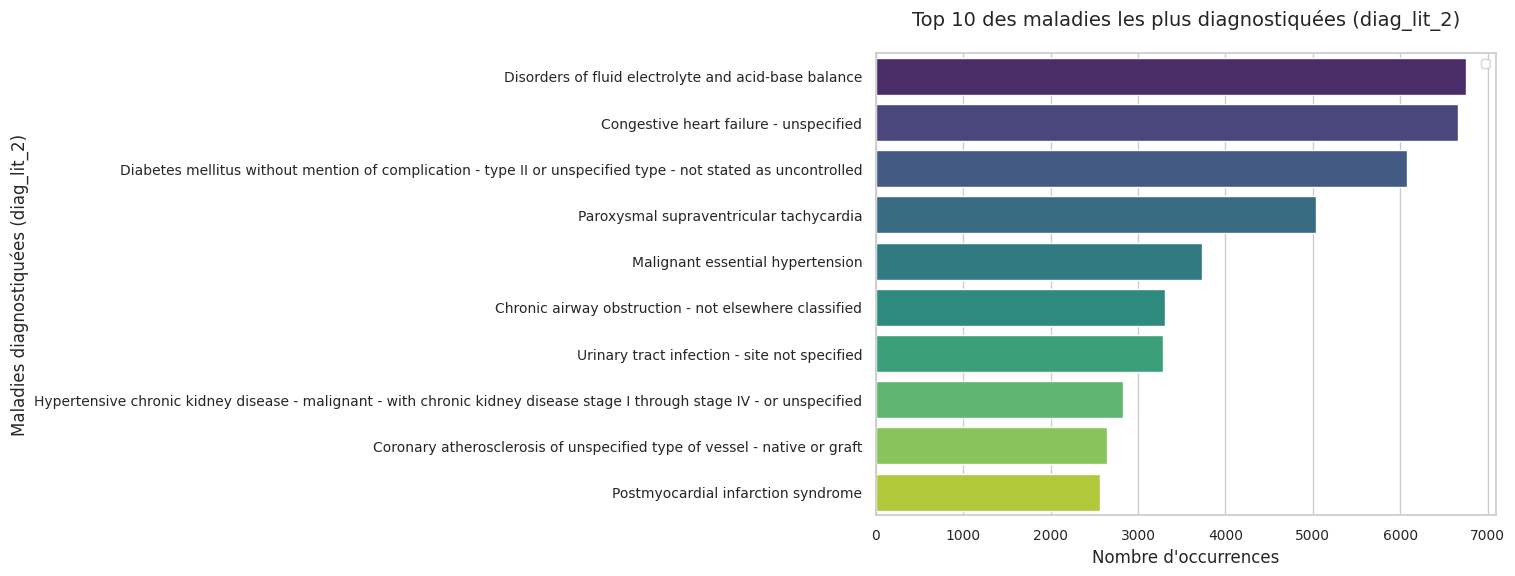

In [ ]:
test_diag_lit_2 = df['diag_lit_2'].value_counts().head(10)

plt.figure(figsize=(8, 6))
sns.barplot(x=test_diag_lit_2.values, y=test_diag_lit_2.index, palette='viridis')
plt.xlabel('Nombre d\'occurrences', fontsize=12)
plt.ylabel('Maladies diagnostiquées (diag_lit_2)', fontsize=12)
plt.title('Top 10 des maladies les plus diagnostiquées (diag_lit_2)', fontsize=14, pad=20)
plt.tick_params(labelsize=10)
plt.tight_layout()

plt.legend(loc='upper right', prop={'size': 8})

plt.savefig('top10_diag2.png')
plt.show()

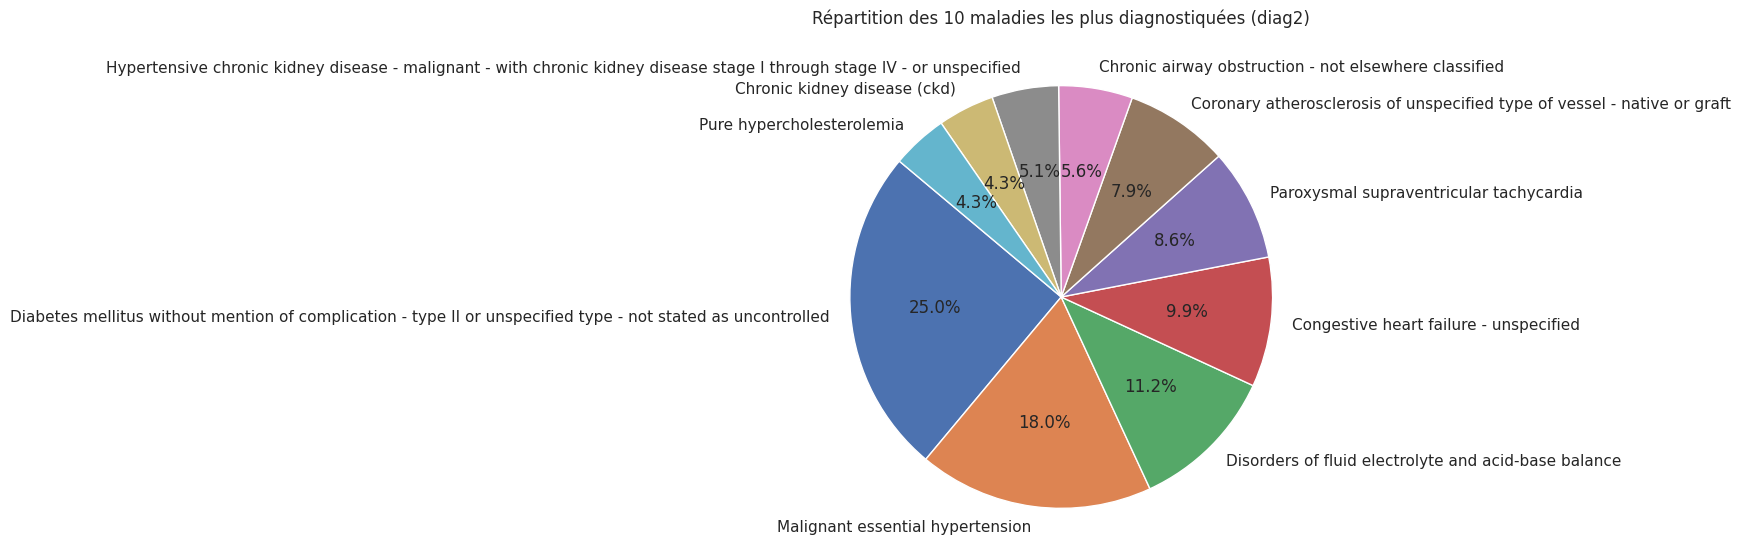

In [ ]:
occurrences_maladies = df['diag_lit_3'].value_counts()
top_10_maladies_3 = occurrences_maladies.head(10)


plt.figure(figsize=(6, 6))
plt.pie(top_10_maladies_3, labels=top_10_maladies_3.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.title('Répartition des 10 maladies les plus diagnostiquées (diag2)',pad=30)
plt.show()


<ipython-input-128-f2ef756ef7ba>:11: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


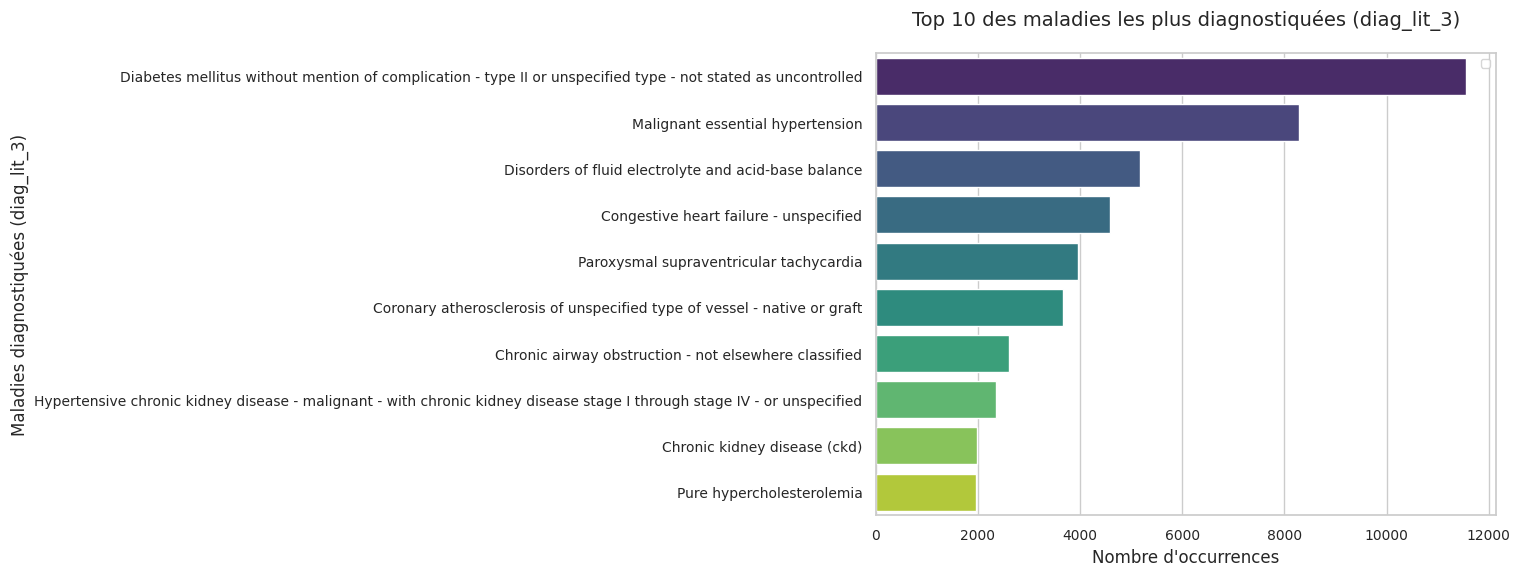

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
test = df['diag_lit_3'].value_counts().head(10)

plt.figure(figsize=(8, 6))
sns.barplot(x=test.values, y=test.index, palette='viridis')
plt.xlabel('Nombre d\'occurrences', fontsize=12)
plt.ylabel('Maladies diagnostiquées (diag_lit_3)', fontsize=12)
plt.title('Top 10 des maladies les plus diagnostiquées (diag_lit_3)', fontsize=14, pad=20)
plt.tick_params(labelsize=10)
plt.tight_layout()

plt.legend(loc='upper right', prop={'size': 8})

plt.savefig('top10_diag3.png')
plt.show()

# Machine Learning


Dans cette partie, nous allons étudier la corrélation qu'il y a entre le fait de prendre des médicaments et avoir été readmis ou non.

Dans un premier temps, nous voyons que nous avons des données catégoriques(No, Down, Steady et Up), nous devons les encoder pour pouvoir utiliser des algorithmes dessus.
Pour cela, nous allons comparer deux types d'encodages: l'ordinal et le onehot.

L'encodage ordinal consiste à remplacer les catégorie par des nombres (0 pour "No" et 1 pour "Down" par exemple). Ce type d'encoodage à l'avantage d'ètre simple mais hiérarchise les catégorie. Dans notre cas, on peut hiérarchiser dans cet ordre : no, down, steady, up. Mais, on ne sait pas quels sont les "distances" entre ces catégories, c'est à dire est-ce que la différence entre NO et down est la même qu'entre Down et Steady.

L'encodage OneHot crée une colonne par catégorie, c'est à dire qu'au lieu d'avoir No et Down pour l'insuline, nous aurons une colonne insuline_no et insuline_down. Cela a l'avantage de ne pas créer de hiérarchie mais cela augmente grandement le nombre de colonnes et donc le temps que prendront les algorithmes à donner un résultat.

Pour limiter le temps que prendront les algorithmes, on se limitera à un échantillon de 5000 lignes.

In [ ]:
X1 = X.copy()

X1.drop(['max_glu_serum', 'A1Cresult',"weight", "medical_specialty", "payer_code","diag_1","diag_2","diag_3",'race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient',
       'number_diagnoses','change', 'diabetesMed',"examide","citoglipton"], axis=1, inplace=True)
#X1.drop(["repaglinide","glyburide-metformin","nateglinide","acarbose","chlorpropamide","tolazamide","miglitol","tolbutamide","glipizide-metformin","troglitazone","metformin-rosiglitazone","acetohexamide","glimepiride-pioglitazone","metformin-pioglitazone"],axis = 1, inplace = True)
X_onehot = pd.get_dummies(X1)
X_ordinal = X1.replace({"No":0,"Down":1,"Steady":2,"Up":3})


In [ ]:
X_onehot

,metformin_Down,metformin_No,metformin_Steady,metformin_Up,repaglinide_Down,repaglinide_No,repaglinide_Steady,repaglinide_Up,nateglinide_Down,nateglinide_No,...,glyburide-metformin_Steady,glyburide-metformin_Up,glipizide-metformin_No,glipizide-metformin_Steady,glimepiride-pioglitazone_No,glimepiride-pioglitazone_Steady,metformin-rosiglitazone_No,metformin-rosiglitazone_Steady,metformin-pioglitazone_No,metformin-pioglitazone_Steady
0,0,1,0,0,0,1,0,0,0,1,...,0,0,1,0,1,0,1,0,1,0
1,0,1,0,0,0,1,0,0,0,1,...,0,0,1,0,1,0,1,0,1,0
2,0,1,0,0,0,1,0,0,0,1,...,0,0,1,0,1,0,1,0,1,0
3,0,1,0,0,0,1,0,0,0,1,...,0,0,1,0,1,0,1,0,1,0
4,0,1,0,0,0,1,0,0,0,1,...,0,0,1,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,0,0,1,0,0,1,0,0,0,1,...,0,0,1,0,1,0,1,0,1,0
101762,0,1,0,0,0,1,0,0,0,1,...,0,0,1,0,1,0,1,0,1,0
101763,0,0,1,0,0,1,0,0,0,1,...,0,0,1,0,1,0,1,0,1,0
101764,0,1,0,0,0,1,0,0,0,1,...,0,0,1,0,1,0,1,0,1,0


In [ ]:
X_ordinal

,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,...,acarbose,miglitol,troglitazone,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,3,0,0,0,0,0
2,0,0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,3,0,0,0,0,0
4,0,0,0,0,0,0,2,0,0,0,...,0,0,0,0,2,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
101762,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0
101763,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
101764,0,0,0,0,0,0,2,0,0,2,...,0,0,0,0,3,0,0,0,0,0


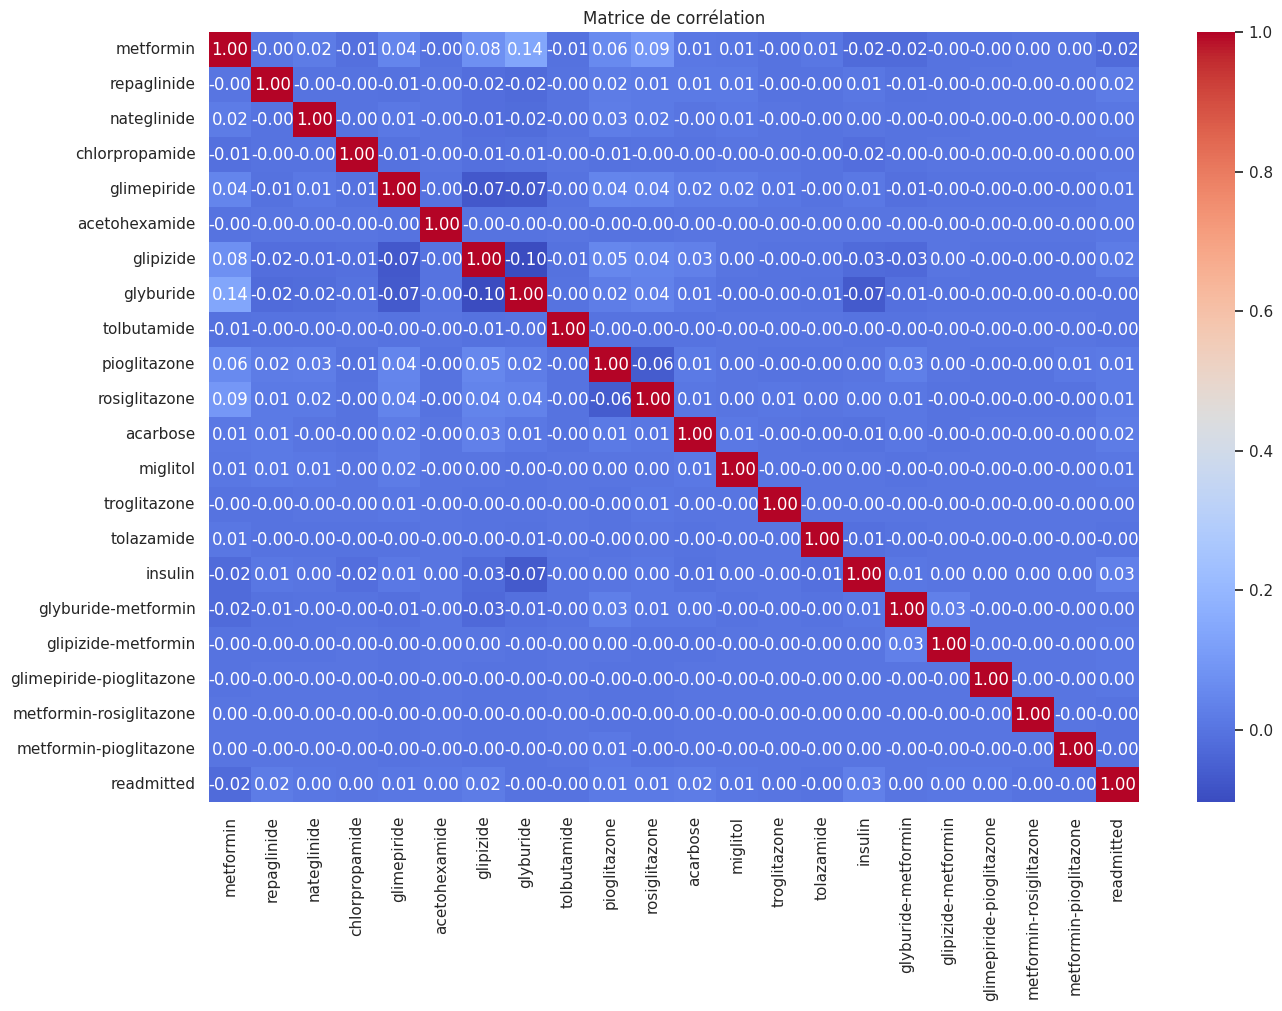

In [ ]:
plt.figure(figsize=(15, 10))
mapping = {"<30":1,">30":2,"NO":0}
y_corr = y["readmitted"].map(mapping)
mat_corr = pd.concat([X_ordinal, y_corr], axis=1)
sns.heatmap(mat_corr.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matrice de corrélation')
plt.show()

On voit dans un premier temps que la prise de médicament semble corrélée avec le fait d'ètre réadmis. Mais nous allons vérifier ça grâce à sklearn.

Faisons maintenant des prédiction.
Nous allons essayer Trois algorithmes:

# 1. Le support vector machine(SVM):
**Type d'algorithme** : SVM est à la fois un algorithme de classification et de régression.

**Principe fondamental** : SVM cherche à trouver un hyperplan optimal dans un espace de grande dimension pour séparer les données de différentes classes.

**Fonctionnement** : Pour la classification binaire, SVM trouve l'hyperplan qui maximise la marge entre les classes. Pour les données non linéaires, il utilise des noyaux (kernel tricks) pour projeter les données dans un espace de plus grande dimension où une séparation linéaire est possible.

**Avantages** : Efficace pour des ensembles de données à haute dimension. Il offre une bonne généralisation et est efficace dans les espaces de caractéristiques non linéaires avec des noyaux appropriés.

**Inconvénients** : Peut être sensible au choix du noyau et à la mise à l'échelle des données. Souvent, la formation peut être coûteuse pour de grands ensembles de données.

# 2. Random Forest:
**Type d'algorithme** : Random Forest est principalement utilisé pour la classification et la régression.

**Principe fondamental** : C'est un ensemble d'arbres de décision où chaque arbre est construit de manière aléatoire à partir d'un sous-ensemble des données d'entraînement.

**Fonctionnement** : Chaque arbre est formé sur un échantillon aléatoire du jeu de données et à chaque division, un sous-ensemble aléatoire de caractéristiques est considéré. Les prédictions sont agrégées pour obtenir la prédiction finale.

**Avantages** : Résistant à la surajustement (overfitting) et performant sur une grande variété de problèmes. Peut gérer efficacement les ensembles de données avec des caractéristiques non linéaires et une grande dimension.

**Inconvénients** : Moins interprétable que les arbres de décision individuels. La construction de nombreux arbres peut nécessiter plus de ressources computationnelles.

# 3. K-Nearest Neighbors (KNN):

**Type d'algorithme** : KNN est un algorithme de classification et de régression.

**Principe fondamental** : Basé sur la similarité des données, il attribue une étiquette à un point en se basant sur les étiquettes des points voisins les plus proches dans l'espace de caractéristiques.

**Fonctionnement** : Pour chaque point à prédire, il trouve les k voisins les plus proches en utilisant une mesure de distance (par exemple, la distance euclidienne) et prend une décision basée sur le vote majoritaire (pour la classification) ou la moyenne (pour la régression) des voisins.

**Avantages** : Simple à comprendre et à implémenter. Il peut s'adapter à différents types de données.

**Inconvénients** : Peut être sensible à la présence de valeurs aberrantes et à la dimension de l'espace. La prédiction peut être coûteuse si le jeu de données est volumineux.

# Onehot

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Précision SVM : 0.556
Précision Random Forest : 0.557
Précision KNN : 0.479


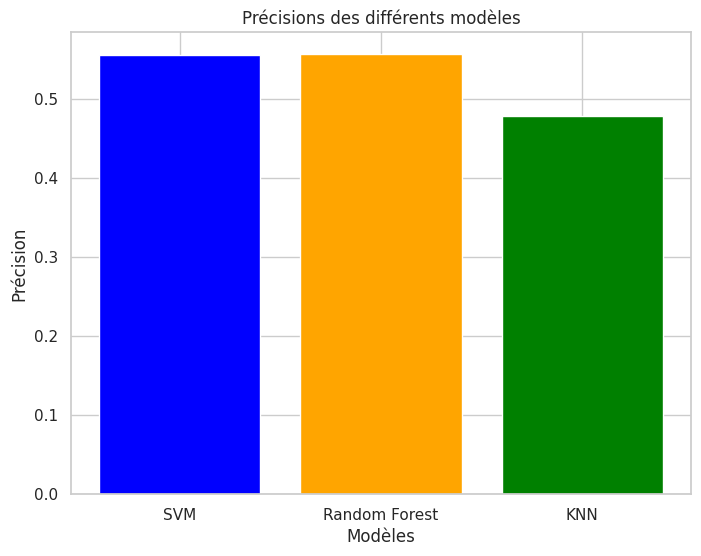

In [ ]:
y = np.ravel(y)
temps = time.time()
n_samples = 5000


X_sampled, y_sampled = resample(X_onehot, y, n_samples=n_samples, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_sampled, y_sampled, test_size=0.2, random_state=42)


param_grid_svm = {
    'C': uniform(0.1, 10),
    'gamma': uniform(0.01, 1),
    'kernel': ['linear', 'rbf']
}

param_grid_random_forest = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 5, 10]
}

param_grid_knn = {
    'n_neighbors': [3, 5, 7],
    'p': [1, 2]
}


svm = RandomizedSearchCV(SVC(), param_distributions=param_grid_svm, n_iter=10, cv=3)
random_forest = RandomizedSearchCV(RandomForestClassifier(), param_distributions=param_grid_random_forest, n_iter=10, cv=3)
knn = RandomizedSearchCV(KNeighborsClassifier(), param_distributions=param_grid_knn, n_iter=10, cv=3)


svm.fit(X_train, y_train)
random_forest.fit(X_train, y_train)
knn.fit(X_train, y_train)


svm_accuracy = svm.best_estimator_.score(X_test, y_test)
rf_accuracy = random_forest.best_estimator_.score(X_test, y_test)
knn_accuracy = knn.best_estimator_.score(X_test, y_test)


plt.figure(figsize=(8, 6))
plt.bar(['SVM', 'Random Forest', 'KNN'],[svm_accuracy, rf_accuracy, knn_accuracy],color=['blue', 'orange', 'green'])
plt.title('Précisions des différents modèles')
plt.xlabel('Modèles')
plt.ylabel('Précision')
plt.savefig("ML.png")
print("Précision SVM :", svm_accuracy)
print("Précision Random Forest :", rf_accuracy)
print("Précision KNN :", knn_accuracy)
temps_onehot = time.time() - temps

On constate une certaine cohérence entre le SVM et le random forest mais le KNN est en deça.

# Ordinal encoding

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Précision SVM : 0.556
Précision Random Forest : 0.557
Précision KNN : 0.461


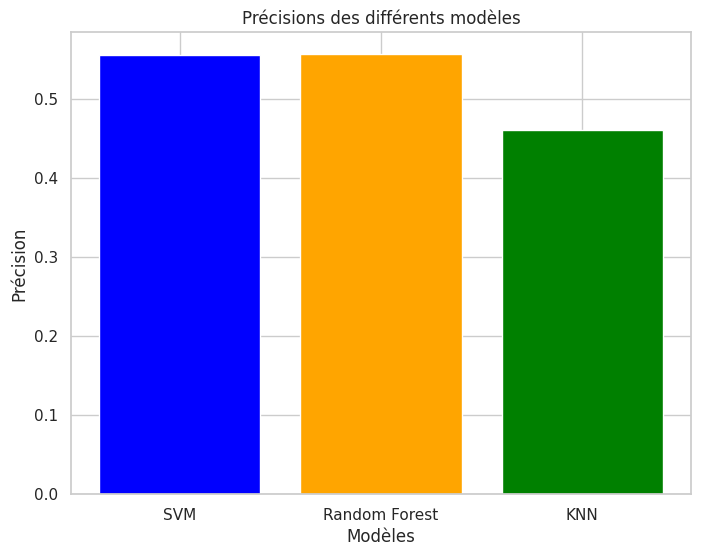

In [ ]:
temps = time.time()

X_sampled, y_sampled = resample(X_ordinal, y, n_samples=n_samples, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_sampled, y_sampled, test_size=0.2, random_state=42)



svm = RandomizedSearchCV(SVC(), param_distributions=param_grid_svm, n_iter=10, cv=3)
random_forest = RandomizedSearchCV(RandomForestClassifier(), param_distributions=param_grid_random_forest, n_iter=10, cv=3)
knn = RandomizedSearchCV(KNeighborsClassifier(), param_distributions=param_grid_knn, n_iter=10, cv=3)


svm.fit(X_train, y_train)
random_forest.fit(X_train, y_train)
knn.fit(X_train, y_train)


svm_accuracy = svm.best_estimator_.score(X_test, y_test)
rf_accuracy = random_forest.best_estimator_.score(X_test, y_test)
knn_accuracy = knn.best_estimator_.score(X_test, y_test)

plt.figure(figsize=(8, 6))
plt.bar(['SVM', 'Random Forest', 'KNN'],[svm_accuracy, rf_accuracy, knn_accuracy],color=['blue', 'orange', 'green'])
plt.title('Précisions des différents modèles')
plt.xlabel('Modèles')
plt.ylabel('Précision')

print("Précision SVM :", svm_accuracy)
print("Précision Random Forest :", rf_accuracy)
print("Précision KNN :", knn_accuracy)
temps_ordinal = time.time() - temps

In [ ]:
print("temps onehot : ",temps_onehot)
print("temps ordinal : ",temps_ordinal)

temps onehot :  32.624338150024414
temps ordinal :  30.24744701385498


On constate des performances équivalentes entre les deux types d'encodage mais l'encodage ordinal est plus rapide.
De plus, on constate une certaine corrélation entre la prise de médicaments et le fait d'être réadmis

# Streamlit

attention, il faut lancer la cellule juste en dessous pour sauvegarder le dataframe qu'on va réimporter dans streamlit.py. C'est le seul moyen que nous avons trouvé afin de raccourcir les chargements de page

In [ ]:
!streamlit run display.py




  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.12:8501
  External URL: http://34.106.68.138:8501

  Stopping...
^C
